<a href="https://colab.research.google.com/github/Lidormon/Topology/blob/main/TM_question_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import networkx as nx

def load_point_cloud(path:str) -> pd.DataFrame:
    """Decode UTF‑16‑LE .csv and return a DataFrame with columns x,y."""
    with open(path, 'rb') as fh:
        txt = fh.read().decode('utf-16-le', errors='ignore')
    nums  = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', txt)
    pairs = [(float(nums[i]), float(nums[i+1]))
             for i in range(0, len(nums)-1, 2)]
    return pd.DataFrame(pairs, columns=['x', 'y'])

Preview:


,x,y
0,-0.088686,-4.887823
1,-0.101376,-4.811397
2,0.282993,-4.550131
3,-0.218560,-4.520474
4,-0.222728,-4.407990


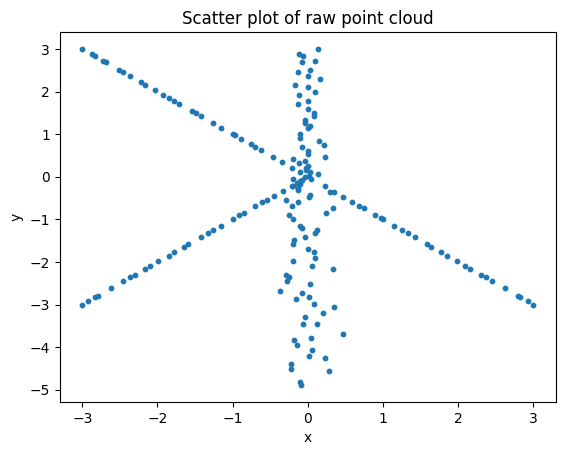

In [ ]:
CSV_FILE = '/content/exploratory_data.csv'   # adjust path in Colab as needed
data = load_point_cloud(CSV_FILE)
X    = data.values

print("Preview:")
display(data.head())

plt.scatter(data.x, data.y, s=10)
plt.title("Scatter plot of raw point cloud")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


In [ ]:
# Candidate 1: PCA‑PC1
pca    = PCA(n_components=1).fit(X)
pc1    = pca.transform(X).ravel()

# Candidate 2: eccentricity
ecc    = ssd.squareform(ssd.pdist(X)).mean(axis=1)

if pca.explained_variance_ratio_[0] > 0.70:   # heuristic threshold
    f_vals, fname = pc1, "PCA‑PC1"
else:
    f_vals, fname = ecc, "Eccentricity"

print("Chosen filter:", fname)
print("  PC‑1  var‑ratio:", pca.explained_variance_ratio_[0])
print("  Ecc   spread   :", ecc.std())


Chosen filter: PCA‑PC1
  PC‑1  var‑ratio: 0.7550224425988419
  Ecc   spread   : 0.7442644942114294


# intervals: 15   overlap: 0.5


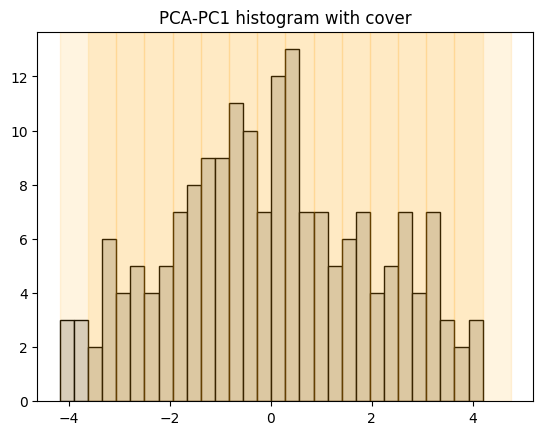

In [ ]:
n_intervals, overlap = 15, 0.50      # tweak here
a, b   = f_vals.min(), f_vals.max()
stride = (b - a) / n_intervals
width  = stride / (1 - overlap)
cover  = [(a + i*stride, a + i*stride + width)
          for i in range(n_intervals)]

print("# intervals:", n_intervals, "  overlap:", overlap)

plt.hist(f_vals, bins=30, color="lightgray", edgecolor="k")
for L, R in cover:
    plt.axvspan(L, R, color="orange", alpha=0.12)
plt.title(f"{fname} histogram with cover"); plt.show()


In [ ]:
eps = np.quantile(ssd.pdist(X), 0.05)   # 10‑th percentile
print("ε (distance threshold) =", eps)

pts_sets = []         # list of point‐index sets for each cluster
for cube_id, (L, R) in enumerate(cover):
    idx = np.where((f_vals >= L) & (f_vals <= R))[0]
    if not len(idx):                        # empty cube
        continue
    if len(idx) == 1:                       # singleton
        pts_sets.append({idx[0]})
    else:
        Z    = linkage(X[idx], method='single')
        labs = fcluster(Z, t=eps, criterion='distance')
        pts_sets.extend({*idx[labs == lbl]} for lbl in np.unique(labs))
print("Total clusters (nodes) =", len(pts_sets))


ε (distance threshold) = 0.45864901519030665
Total clusters (nodes) = 27


nodes: 27 edges: 26


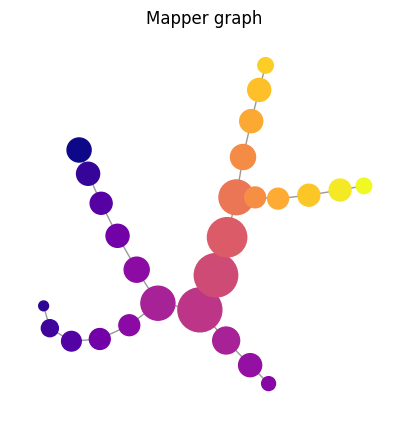

In [ ]:
G = nx.Graph()
# add nodes
for i, s in enumerate(pts_sets):
    G.add_node(i, size=len(s), mean_f=f_vals[list(s)].mean())

# add edges (overlapping clusters)
for i in range(len(pts_sets)):
    for j in range(i+1, len(pts_sets)):
        if pts_sets[i] & pts_sets[j]:
            G.add_edge(i, j)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# static plot
pos   = nx.spring_layout(G, seed=42)
sizes = [G.nodes[n]['size']*25 for n in G]
cols  = [G.nodes[n]['mean_f']  for n in G]

plt.figure(figsize=(5,5))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=cols, cmap='plasma')
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.title("Mapper graph"); plt.axis('off'); plt.show()


In [ ]:
# Instantiate kmapper
mapper = kmapper.KeplerMapper(verbose=0)

# Fit to data and create a graph
# The 'projected' variable from the previous cells can be used as the projected data
graph = mapper.map(
    f_vals.reshape(-1, 1), # Use the filter values as the projected data
    X, # Use the original data for clustering
    cover=kmapper.Cover(n_cubes=n_intervals, perc_overlap=overlap),
    clusterer=None # Clustering is already done in the previous steps
)

# Visualize the graph
mapper.visualize(graph, path_html="mapper_output.html", title="Mapper Graph")

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weight

In [ ]:
from google.colab import files

files.download('mapper_output.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
components = list(nx.connected_components(G))
beta1      = len(nx.cycle_basis(G))
branching  = [n for n,d in G.degree() if d >= 3]

print("Connected components :", len(components))
print("First Betti number β₁:", beta1)
print("Branching nodes (deg≥3):", branching)


Connected components : 1
First Betti number β₁: 0
Branching nodes (deg≥3): [13, 14, 17]


In [ ]:
if len(components)==1 and beta1==0 and len(branching)>=1:
    inferred_shape = "three‑arm star (Y‑shape)"
else:
    inferred_shape = "complex / needs inspection"

print("===============================================")
print("Topological conclusion:", inferred_shape)
print("Reasoning:")
print(" • single component  ⇒ globally connected")
print(" • β₁ = 0            ⇒ no macroscopic loops")
print(" • hub + 3 branches  ⇒ Y‑like geometry")


Topological conclusion: three‑arm star (Y‑shape)
Reasoning:
 • single component  ⇒ globally connected
 • β₁ = 0            ⇒ no macroscopic loops
 • hub + 3 branches  ⇒ Y‑like geometry


In [ ]:
# 🔹 Cell N – Summary of answers (i) – (v)
# (run AFTER the earlier cells so the variables already exist)

summary = f"""
(i) Filter choice
    • Chosen filter             : {fname}
    • PCA‑PC1 var‑ratio         : {pca.explained_variance_ratio_[0]:.3f}
    • Eccentricity spread (std) : {ecc.std():.3f}

(ii) Cover parameters
    • # intervals               : {n_intervals}
    • Overlap                   : {overlap:.0%}
    • Interval width            : {(cover[0][1]-cover[0][0]):.3f}

(iii) Clustering in each cube
    • Algorithm                 : single‑linkage
    • ε (distance threshold)    : {eps:.3f}

(iv) Mapper graph
    • Visualisation appears in the previous graph cell
      (static plot or interactive HTML).

(v) Topological interpretation
    • Connected components      : {len(components)}
    • First Betti number β₁     : {beta1}
    • Branching nodes (deg≥3)   : {len(branching)}
    • Inferred underlying shape : {inferred_shape}
"""

print(summary)


(i) Filter choice
    • Chosen filter             : PCA‑PC1
    • PCA‑PC1 var‑ratio         : 0.755
    • Eccentricity spread (std) : 0.744

(ii) Cover parameters
    • # intervals               : 15
    • Overlap                   : 50%
    • Interval width            : 1.117

(iii) Clustering in each cube
    • Algorithm                 : single‑linkage
    • ε (distance threshold)    : 0.459

(iv) Mapper graph
    • Visualisation appears in the previous graph cell
      (static plot or interactive HTML).

(v) Topological interpretation
    • Connected components      : 1
    • First Betti number β₁     : 0
    • Branching nodes (deg≥3)   : 3
    • Inferred underlying shape : three‑arm star (Y‑shape)

